In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

In [500]:
%matplotlib inline

In [501]:
df = pd.read_csv('dataset-0510/train.csv')

In [442]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


## Check for missing data

In [189]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

In [190]:
missing_data = pd.concat([total, percent], keys=['Total', 'Percent'], axis = 1)

總共有 4 個 column 有 missing data
- parking_area 和 parking_price 缺太多資料補不了只好刪了
- 看一下 txn_floor 和 village_income_median 能不能捕

In [191]:
missing_data.head()

,Total,Percent
parking_area,56897,0.948283
parking_price,46065,0.767750
txn_floor,15902,0.265033
village_income_median,1142,0.019033
total_price,0,0.000000


In [325]:
df_txn_floor_notnull = df[df['txn_floor'].notnull()]
df_village_income_median_notnull = df[df['village_income_median'].notnull()]

畫出交易樓層跟平均價格的關係
- 看似好像有點關聯

,total_price,txn_floor
total_price,1.000000,0.046155
txn_floor,0.046155,1.000000


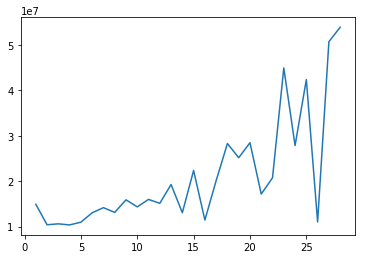

In [193]:
plt.plot(df_txn_floor_notnull.groupby(['txn_floor'])['total_price'].mean())
df_txn_floor_notnull[['total_price','txn_floor']].corr()

In [503]:
df['txn_floor'].fillna(df['total_floor'] // 2, inplace=True)

In [504]:
df['txn_floor'] = df['txn_floor'].astype('int64')

但發現大部分的數據其實是集中在 1- 7 樓，而上面的關係圖在 1 - 7 樓並沒有明確的關係，所以果斷捨棄這個 column

接下來看一下 village_income_median 能否補值

count    58858.000000
mean       674.840175
std        140.653083
min        411.000000
25%        583.000000
50%        642.000000
75%        729.000000
max       1851.000000
Name: village_income_median, dtype: float64


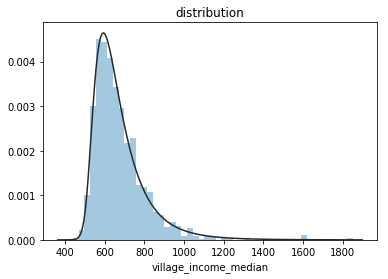

In [194]:
# plt.plot(df_txn_floor_notnull.groupby(['village_income_median'])['total_price'].mean())
print(df_village_income_median_notnull['village_income_median'].describe())
df_village_income_median_notnull[['total_price','village_income_median']].corr()
y = df_village_income_median_notnull['village_income_median']
plt.figure(1); plt.title('distribution')
sns.distplot(y, kde=False, fit=sp.stats.johnsonsu)

決定用同個 town 的 village_income_median 來填空值

In [477]:
#s = df.groupby('town')['village_income_median'].median()
#df['village_income_median'].fillna(df['town'].map(s), inplace=True)

In [505]:
#df['village_income_median'].fillna(df['village_income_median'].mean(),inplace=True)
df['village_income_median'].fillna(df['village_income_median'].mode()[0], inplace=True)

In [506]:
df.drop(['parking_area','parking_price'],axis=1,inplace=True)

有些 column 裡面只有一種 value，代表大家都有相同的資料

In [403]:
one_value_column = [i for i in df.columns if len(df[i].unique()) < 2]

In [404]:
df.drop(one_value_column,axis=1,inplace=True)

- 到此為止 df 所做的修改就只有把一些沒用的 column 丟掉跟補一些缺值

# 資料處理

- 先把名稱中含有 index 的 column 找出來，他們都是 categorical data
- 再手動把一些 categorical data 標出來
- categorical data: 共 54 個 (不包括 town 跟 village 因為他們種類太多了)
- numerical data: 共 156 個 (全部的 col 減掉 categorical data)

In [507]:
categorical = []

In [508]:
cat = ['total_floor','building_material',
       'city','building_type','txn_floor',
       'building_use','parking_way']

In [509]:
categorical = cat + categorical

In [510]:
numerical = [i for i in df.columns if i not in categorical]

- 把不同種類區分出來之後下一步就是要 get_dummy
- 但為了要一次轉換好必須先把類別資料 type 轉成 str

In [511]:
for col in categorical:
    df[col] = df[col].astype(str)

In [512]:
df_dummy = pd.get_dummies(df[categorical])
# df_dummy.info()

- 接著把轉換好的 dataframe 跟 numerical 的 dataframe 合併

In [513]:
df_after = pd.concat([df[numerical],df_dummy], axis=1) 

- 把剛剛那些步驟寫成 function 為了給之後的 testing data 使用

In [487]:
def dummy_transform(df):
    categorical = []
    cat = ['total_floor','building_material',
       'city','building_type','txn_floor',
       'building_use','parking_way']
    categorical = cat + categorical
    numerical = [i for i in df.columns if i not in categorical]
    for col in categorical:
        df[col] = df[col].astype(str)
    df_dummy = pd.get_dummies(df[categorical])
    return pd.concat([df[numerical],df_dummy], axis=1) 

In [514]:
df_after['village_income_median'].isnull().sum()

0

- load testing data 進來

In [515]:
test = pd.read_csv('dataset-0510/test.csv')

In [516]:
fill_val = test['village_income_median'].mode()[0]  # 634
test['village_income_median'] = test['village_income_median'].fillna(fill_val)
# s = test.groupby('town')['village_income_median'].median()
# test['village_income_median'].fillna(test['town'].map(s), inplace=True)
# test['village_income_median'].fillna(test['village_income_median'].mean(),inplace=True)
test['txn_floor'].fillna(test['total_floor'] // 2, inplace=True)
test['txn_floor'] = test['txn_floor'].astype('int64')

In [368]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'txn_floor',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=233)

In [517]:
test = test[df.columns[:-1]]
test = dummy_transform(test)

In [492]:
test.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 319 columns):
building_id                10000 non-null object
txn_dt                     10000 non-null int64
building_complete_dt       10000 non-null int64
land_area                  10000 non-null float64
building_area              10000 non-null float64
town                       10000 non-null int64
lat                        10000 non-null float64
lon                        10000 non-null float64
village_income_median      10000 non-null float64
town_population            10000 non-null float64
town_area                  10000 non-null float64
town_population_density    10000 non-null float64
doc_rate                   10000 non-null float64
master_rate                10000 non-null float64
bachelor_rate              10000 non-null float64
jobschool_rate             10000 non-null float64
highschool_rate            10000 non-null float64
junior_rate                10000 non-null float6

- 發現 training data 裡面有些 column 在 testing data 裡面沒有
    - XI_index_10000_0
    - building_material_5

In [518]:
set(df_after.columns) - set(test.columns)

{'building_material_5', 'total_price', 'txn_floor_28'}

In [522]:
# test['building_material_5'] = 0
# test['txn_floor_28'] = 0
df_after.drop(['building_material_5','txn_floor_28'], axis=1, inplace=True)
# df_after['building_material_5'].head()

# 產生要訓練 model 的資料

In [523]:
y = np.log1p(df_after["total_price"])

In [524]:
X = df_after.drop(['building_id','total_price'],axis=1)

In [525]:
X_valid = X[50000:]
y_valid = y[50000:]
X = X[:50000]
y = y[:50000]

In [526]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 50000 to 59999
Columns: 318 entries, txn_dt to parking_way_2
dtypes: float64(33), int64(191), uint8(94)
memory usage: 18.0 MB


# Training

In [142]:
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance

In [130]:
def validation(prediction, ground_true):
    ground_true = np.floor(np.expm1(ground_true))
    ground_true = ground_true.reset_index(drop=True)
    
    prediction = np.floor(np.expm1(prediction))
    
    score = 0
    for i in range(len(prediction)):
        pred = prediction[i]
        roof = ground_true[i] + ground_true[i] / 10
        floor = ground_true[i] - ground_true[i] / 10
        if (pred <= roof) and (pred >= floor):
            score += 1
    return score

In [527]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=5000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    nthread=8,
    seed=41)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 80)


[0]	validation_0-rmse:13.5616	validation_1-rmse:13.5563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 80 rounds.
[1]	validation_0-rmse:12.2099	validation_1-rmse:12.2057
[2]	validation_0-rmse:10.9921	validation_1-rmse:10.9892
[3]	validation_0-rmse:9.89588	validation_1-rmse:9.8941
[4]	validation_0-rmse:8.90939	validation_1-rmse:8.90794
[5]	validation_0-rmse:8.02169	validation_1-rmse:8.02105
[6]	validation_0-rmse:7.22314	validation_1-rmse:7.22319
[7]	validation_0-rmse:6.50431	validation_1-rmse:6.50521
[8]	validation_0-rmse:5.85729	validation_1-rmse:5.85895
[9]	validation_0-rmse:5.27528	validation_1-rmse:5.27728
[10]	validation_0-rmse:4.75167	validation_1-rmse:4.75419
[11]	validation_0-rmse:4.28046	validation_1-rmse:4.28335
[12]	validation_0-rmse:3.85661	validation_1-rmse:3.85967
[13]	validation_0-rmse:3.47547	validation_1-rmse:3.47854
[14]	validation_0-rmse:3.13267	validation_1-rmse:3.135

[138]	validation_0-rmse:0.23093	validation_1-rmse:0.247454
[139]	validation_0-rmse:0.230543	validation_1-rmse:0.247175
[140]	validation_0-rmse:0.230236	validation_1-rmse:0.246903
[141]	validation_0-rmse:0.229812	validation_1-rmse:0.246543
[142]	validation_0-rmse:0.229684	validation_1-rmse:0.246473
[143]	validation_0-rmse:0.22935	validation_1-rmse:0.246175
[144]	validation_0-rmse:0.228971	validation_1-rmse:0.245881
[145]	validation_0-rmse:0.228778	validation_1-rmse:0.245755
[146]	validation_0-rmse:0.228576	validation_1-rmse:0.245654
[147]	validation_0-rmse:0.228313	validation_1-rmse:0.245502
[148]	validation_0-rmse:0.228009	validation_1-rmse:0.245302
[149]	validation_0-rmse:0.227817	validation_1-rmse:0.245204
[150]	validation_0-rmse:0.227654	validation_1-rmse:0.245115
[151]	validation_0-rmse:0.227504	validation_1-rmse:0.245109
[152]	validation_0-rmse:0.227389	validation_1-rmse:0.245043
[153]	validation_0-rmse:0.227216	validation_1-rmse:0.244922
[154]	validation_0-rmse:0.227102	validatio

[276]	validation_0-rmse:0.209397	validation_1-rmse:0.234387
[277]	validation_0-rmse:0.209306	validation_1-rmse:0.23438
[278]	validation_0-rmse:0.209259	validation_1-rmse:0.234348
[279]	validation_0-rmse:0.209188	validation_1-rmse:0.234315
[280]	validation_0-rmse:0.209124	validation_1-rmse:0.234286
[281]	validation_0-rmse:0.208987	validation_1-rmse:0.234232
[282]	validation_0-rmse:0.208797	validation_1-rmse:0.234115
[283]	validation_0-rmse:0.208749	validation_1-rmse:0.234064
[284]	validation_0-rmse:0.208689	validation_1-rmse:0.234016
[285]	validation_0-rmse:0.208616	validation_1-rmse:0.234006
[286]	validation_0-rmse:0.20854	validation_1-rmse:0.233966
[287]	validation_0-rmse:0.208407	validation_1-rmse:0.233899
[288]	validation_0-rmse:0.208249	validation_1-rmse:0.233758
[289]	validation_0-rmse:0.208106	validation_1-rmse:0.23373
[290]	validation_0-rmse:0.208053	validation_1-rmse:0.233683
[291]	validation_0-rmse:0.207935	validation_1-rmse:0.2336
[292]	validation_0-rmse:0.207858	validation_1

[414]	validation_0-rmse:0.196761	validation_1-rmse:0.228429
[415]	validation_0-rmse:0.196735	validation_1-rmse:0.228398
[416]	validation_0-rmse:0.196665	validation_1-rmse:0.228363
[417]	validation_0-rmse:0.196594	validation_1-rmse:0.228333
[418]	validation_0-rmse:0.196569	validation_1-rmse:0.228345
[419]	validation_0-rmse:0.196462	validation_1-rmse:0.228326
[420]	validation_0-rmse:0.196425	validation_1-rmse:0.228301
[421]	validation_0-rmse:0.196319	validation_1-rmse:0.22827
[422]	validation_0-rmse:0.196216	validation_1-rmse:0.228241
[423]	validation_0-rmse:0.196116	validation_1-rmse:0.228189
[424]	validation_0-rmse:0.196057	validation_1-rmse:0.228143
[425]	validation_0-rmse:0.195934	validation_1-rmse:0.228097
[426]	validation_0-rmse:0.195885	validation_1-rmse:0.228123
[427]	validation_0-rmse:0.195805	validation_1-rmse:0.228097
[428]	validation_0-rmse:0.19573	validation_1-rmse:0.228099
[429]	validation_0-rmse:0.195513	validation_1-rmse:0.228003
[430]	validation_0-rmse:0.195306	validatio

[551]	validation_0-rmse:0.187188	validation_1-rmse:0.224538
[552]	validation_0-rmse:0.18711	validation_1-rmse:0.224507
[553]	validation_0-rmse:0.187087	validation_1-rmse:0.224525
[554]	validation_0-rmse:0.187027	validation_1-rmse:0.224494
[555]	validation_0-rmse:0.18701	validation_1-rmse:0.224484
[556]	validation_0-rmse:0.186878	validation_1-rmse:0.224429
[557]	validation_0-rmse:0.186786	validation_1-rmse:0.224406
[558]	validation_0-rmse:0.186724	validation_1-rmse:0.224367
[559]	validation_0-rmse:0.186672	validation_1-rmse:0.224342
[560]	validation_0-rmse:0.186585	validation_1-rmse:0.22431
[561]	validation_0-rmse:0.186495	validation_1-rmse:0.22425
[562]	validation_0-rmse:0.186434	validation_1-rmse:0.224199
[563]	validation_0-rmse:0.186346	validation_1-rmse:0.224141
[564]	validation_0-rmse:0.18624	validation_1-rmse:0.224132
[565]	validation_0-rmse:0.186226	validation_1-rmse:0.22413
[566]	validation_0-rmse:0.186207	validation_1-rmse:0.224141
[567]	validation_0-rmse:0.186096	validation_1-

[689]	validation_0-rmse:0.179113	validation_1-rmse:0.221772
[690]	validation_0-rmse:0.179053	validation_1-rmse:0.221739
[691]	validation_0-rmse:0.179015	validation_1-rmse:0.221742
[692]	validation_0-rmse:0.178989	validation_1-rmse:0.221729
[693]	validation_0-rmse:0.178919	validation_1-rmse:0.221728
[694]	validation_0-rmse:0.178855	validation_1-rmse:0.221718
[695]	validation_0-rmse:0.178786	validation_1-rmse:0.221683
[696]	validation_0-rmse:0.178716	validation_1-rmse:0.221668
[697]	validation_0-rmse:0.178658	validation_1-rmse:0.221674
[698]	validation_0-rmse:0.178644	validation_1-rmse:0.221658
[699]	validation_0-rmse:0.17859	validation_1-rmse:0.221659
[700]	validation_0-rmse:0.178543	validation_1-rmse:0.221635
[701]	validation_0-rmse:0.17843	validation_1-rmse:0.221631
[702]	validation_0-rmse:0.178378	validation_1-rmse:0.221622
[703]	validation_0-rmse:0.178334	validation_1-rmse:0.221615
[704]	validation_0-rmse:0.178256	validation_1-rmse:0.221595
[705]	validation_0-rmse:0.178213	validatio

[826]	validation_0-rmse:0.171673	validation_1-rmse:0.219164
[827]	validation_0-rmse:0.171651	validation_1-rmse:0.219142
[828]	validation_0-rmse:0.171527	validation_1-rmse:0.219104
[829]	validation_0-rmse:0.171504	validation_1-rmse:0.219092
[830]	validation_0-rmse:0.171477	validation_1-rmse:0.219075
[831]	validation_0-rmse:0.171446	validation_1-rmse:0.21907
[832]	validation_0-rmse:0.171424	validation_1-rmse:0.219053
[833]	validation_0-rmse:0.171414	validation_1-rmse:0.219042
[834]	validation_0-rmse:0.171357	validation_1-rmse:0.219009
[835]	validation_0-rmse:0.171275	validation_1-rmse:0.219029
[836]	validation_0-rmse:0.171232	validation_1-rmse:0.219028
[837]	validation_0-rmse:0.1712	validation_1-rmse:0.219014
[838]	validation_0-rmse:0.171146	validation_1-rmse:0.218998
[839]	validation_0-rmse:0.171096	validation_1-rmse:0.218996
[840]	validation_0-rmse:0.171044	validation_1-rmse:0.218984
[841]	validation_0-rmse:0.170949	validation_1-rmse:0.218933
[842]	validation_0-rmse:0.170932	validation

[964]	validation_0-rmse:0.165681	validation_1-rmse:0.217604
[965]	validation_0-rmse:0.165658	validation_1-rmse:0.217582
[966]	validation_0-rmse:0.165647	validation_1-rmse:0.217578
[967]	validation_0-rmse:0.165615	validation_1-rmse:0.217582
[968]	validation_0-rmse:0.165477	validation_1-rmse:0.217516
[969]	validation_0-rmse:0.165431	validation_1-rmse:0.217495
[970]	validation_0-rmse:0.165405	validation_1-rmse:0.2175
[971]	validation_0-rmse:0.165365	validation_1-rmse:0.217506
[972]	validation_0-rmse:0.165309	validation_1-rmse:0.217509
[973]	validation_0-rmse:0.16525	validation_1-rmse:0.217514
[974]	validation_0-rmse:0.165233	validation_1-rmse:0.217509
[975]	validation_0-rmse:0.165212	validation_1-rmse:0.217517
[976]	validation_0-rmse:0.165151	validation_1-rmse:0.21751
[977]	validation_0-rmse:0.165134	validation_1-rmse:0.217518
[978]	validation_0-rmse:0.165112	validation_1-rmse:0.217516
[979]	validation_0-rmse:0.165075	validation_1-rmse:0.217491
[980]	validation_0-rmse:0.165055	validation_

[1100]	validation_0-rmse:0.15958	validation_1-rmse:0.216092
[1101]	validation_0-rmse:0.159543	validation_1-rmse:0.216083
[1102]	validation_0-rmse:0.159514	validation_1-rmse:0.216077
[1103]	validation_0-rmse:0.159479	validation_1-rmse:0.216086
[1104]	validation_0-rmse:0.159461	validation_1-rmse:0.216087
[1105]	validation_0-rmse:0.15942	validation_1-rmse:0.216059
[1106]	validation_0-rmse:0.159358	validation_1-rmse:0.216072
[1107]	validation_0-rmse:0.159333	validation_1-rmse:0.216064
[1108]	validation_0-rmse:0.159323	validation_1-rmse:0.216066
[1109]	validation_0-rmse:0.159271	validation_1-rmse:0.216036
[1110]	validation_0-rmse:0.159226	validation_1-rmse:0.216027
[1111]	validation_0-rmse:0.159181	validation_1-rmse:0.216001
[1112]	validation_0-rmse:0.159139	validation_1-rmse:0.215988
[1113]	validation_0-rmse:0.159098	validation_1-rmse:0.216002
[1114]	validation_0-rmse:0.159049	validation_1-rmse:0.216019
[1115]	validation_0-rmse:0.159011	validation_1-rmse:0.215997
[1116]	validation_0-rmse:0

[1235]	validation_0-rmse:0.15414	validation_1-rmse:0.214902
[1236]	validation_0-rmse:0.154114	validation_1-rmse:0.214911
[1237]	validation_0-rmse:0.154093	validation_1-rmse:0.214913
[1238]	validation_0-rmse:0.154072	validation_1-rmse:0.21491
[1239]	validation_0-rmse:0.154012	validation_1-rmse:0.214911
[1240]	validation_0-rmse:0.154003	validation_1-rmse:0.214916
[1241]	validation_0-rmse:0.153968	validation_1-rmse:0.214903
[1242]	validation_0-rmse:0.153902	validation_1-rmse:0.214894
[1243]	validation_0-rmse:0.15387	validation_1-rmse:0.214889
[1244]	validation_0-rmse:0.153837	validation_1-rmse:0.214866
[1245]	validation_0-rmse:0.153825	validation_1-rmse:0.214844
[1246]	validation_0-rmse:0.153767	validation_1-rmse:0.214814
[1247]	validation_0-rmse:0.153722	validation_1-rmse:0.214835
[1248]	validation_0-rmse:0.153694	validation_1-rmse:0.214848
[1249]	validation_0-rmse:0.153626	validation_1-rmse:0.214825
[1250]	validation_0-rmse:0.153571	validation_1-rmse:0.214843
[1251]	validation_0-rmse:0.

[1370]	validation_0-rmse:0.148752	validation_1-rmse:0.21393
[1371]	validation_0-rmse:0.148702	validation_1-rmse:0.213939
[1372]	validation_0-rmse:0.148675	validation_1-rmse:0.21394
[1373]	validation_0-rmse:0.14862	validation_1-rmse:0.213926
[1374]	validation_0-rmse:0.148579	validation_1-rmse:0.213926
[1375]	validation_0-rmse:0.148503	validation_1-rmse:0.213902
[1376]	validation_0-rmse:0.148443	validation_1-rmse:0.213859
[1377]	validation_0-rmse:0.14838	validation_1-rmse:0.213875
[1378]	validation_0-rmse:0.148349	validation_1-rmse:0.213878
[1379]	validation_0-rmse:0.148279	validation_1-rmse:0.213857
[1380]	validation_0-rmse:0.148235	validation_1-rmse:0.213829
[1381]	validation_0-rmse:0.148162	validation_1-rmse:0.213827
[1382]	validation_0-rmse:0.148103	validation_1-rmse:0.213834
[1383]	validation_0-rmse:0.148077	validation_1-rmse:0.213844
[1384]	validation_0-rmse:0.14804	validation_1-rmse:0.213819
[1385]	validation_0-rmse:0.147988	validation_1-rmse:0.213792
[1386]	validation_0-rmse:0.14

[1505]	validation_0-rmse:0.143809	validation_1-rmse:0.213051
[1506]	validation_0-rmse:0.143785	validation_1-rmse:0.213041
[1507]	validation_0-rmse:0.143732	validation_1-rmse:0.213035
[1508]	validation_0-rmse:0.143705	validation_1-rmse:0.213039
[1509]	validation_0-rmse:0.143636	validation_1-rmse:0.21301
[1510]	validation_0-rmse:0.143614	validation_1-rmse:0.213027
[1511]	validation_0-rmse:0.143575	validation_1-rmse:0.213007
[1512]	validation_0-rmse:0.143563	validation_1-rmse:0.212987
[1513]	validation_0-rmse:0.143529	validation_1-rmse:0.212956
[1514]	validation_0-rmse:0.143492	validation_1-rmse:0.212925
[1515]	validation_0-rmse:0.143469	validation_1-rmse:0.212908
[1516]	validation_0-rmse:0.143462	validation_1-rmse:0.212919
[1517]	validation_0-rmse:0.143399	validation_1-rmse:0.212897
[1518]	validation_0-rmse:0.143379	validation_1-rmse:0.21289
[1519]	validation_0-rmse:0.143354	validation_1-rmse:0.212865
[1520]	validation_0-rmse:0.143333	validation_1-rmse:0.212839
[1521]	validation_0-rmse:0

[1640]	validation_0-rmse:0.139658	validation_1-rmse:0.212239
[1641]	validation_0-rmse:0.139598	validation_1-rmse:0.212245
[1642]	validation_0-rmse:0.139575	validation_1-rmse:0.212265
[1643]	validation_0-rmse:0.139531	validation_1-rmse:0.212262
[1644]	validation_0-rmse:0.139488	validation_1-rmse:0.212259
[1645]	validation_0-rmse:0.139479	validation_1-rmse:0.212256
[1646]	validation_0-rmse:0.13944	validation_1-rmse:0.212236
[1647]	validation_0-rmse:0.139402	validation_1-rmse:0.212231
[1648]	validation_0-rmse:0.139382	validation_1-rmse:0.212208
[1649]	validation_0-rmse:0.139361	validation_1-rmse:0.212202
[1650]	validation_0-rmse:0.139346	validation_1-rmse:0.212218
[1651]	validation_0-rmse:0.139309	validation_1-rmse:0.212234
[1652]	validation_0-rmse:0.13925	validation_1-rmse:0.212233
[1653]	validation_0-rmse:0.139232	validation_1-rmse:0.212231
[1654]	validation_0-rmse:0.139218	validation_1-rmse:0.212224
[1655]	validation_0-rmse:0.139156	validation_1-rmse:0.212199
[1656]	validation_0-rmse:0

[1775]	validation_0-rmse:0.135261	validation_1-rmse:0.211888
[1776]	validation_0-rmse:0.135232	validation_1-rmse:0.211888
[1777]	validation_0-rmse:0.135215	validation_1-rmse:0.211878
[1778]	validation_0-rmse:0.135192	validation_1-rmse:0.211868
[1779]	validation_0-rmse:0.13516	validation_1-rmse:0.211843
[1780]	validation_0-rmse:0.13511	validation_1-rmse:0.211816
[1781]	validation_0-rmse:0.135045	validation_1-rmse:0.211809
[1782]	validation_0-rmse:0.135016	validation_1-rmse:0.211814
[1783]	validation_0-rmse:0.134992	validation_1-rmse:0.211815
[1784]	validation_0-rmse:0.134973	validation_1-rmse:0.21182
[1785]	validation_0-rmse:0.134939	validation_1-rmse:0.211809
[1786]	validation_0-rmse:0.134935	validation_1-rmse:0.211816
[1787]	validation_0-rmse:0.134906	validation_1-rmse:0.211825
[1788]	validation_0-rmse:0.134889	validation_1-rmse:0.211833
[1789]	validation_0-rmse:0.134824	validation_1-rmse:0.211805
[1790]	validation_0-rmse:0.134748	validation_1-rmse:0.211774
[1791]	validation_0-rmse:0.

[1910]	validation_0-rmse:0.131083	validation_1-rmse:0.211564
[1911]	validation_0-rmse:0.131036	validation_1-rmse:0.21156
[1912]	validation_0-rmse:0.13102	validation_1-rmse:0.211567
[1913]	validation_0-rmse:0.130986	validation_1-rmse:0.211555
[1914]	validation_0-rmse:0.130966	validation_1-rmse:0.211552
[1915]	validation_0-rmse:0.130948	validation_1-rmse:0.21155
[1916]	validation_0-rmse:0.130926	validation_1-rmse:0.211543
[1917]	validation_0-rmse:0.130918	validation_1-rmse:0.21154
[1918]	validation_0-rmse:0.130889	validation_1-rmse:0.211532
[1919]	validation_0-rmse:0.130883	validation_1-rmse:0.211538
[1920]	validation_0-rmse:0.130873	validation_1-rmse:0.211538
[1921]	validation_0-rmse:0.130832	validation_1-rmse:0.211547
[1922]	validation_0-rmse:0.130787	validation_1-rmse:0.211524
[1923]	validation_0-rmse:0.130701	validation_1-rmse:0.211517
[1924]	validation_0-rmse:0.130695	validation_1-rmse:0.211508
[1925]	validation_0-rmse:0.130668	validation_1-rmse:0.211494
[1926]	validation_0-rmse:0.1

[2045]	validation_0-rmse:0.127089	validation_1-rmse:0.211117
[2046]	validation_0-rmse:0.127062	validation_1-rmse:0.21111
[2047]	validation_0-rmse:0.127033	validation_1-rmse:0.21112
[2048]	validation_0-rmse:0.126999	validation_1-rmse:0.211124
[2049]	validation_0-rmse:0.12695	validation_1-rmse:0.211125
[2050]	validation_0-rmse:0.126939	validation_1-rmse:0.21111
[2051]	validation_0-rmse:0.126923	validation_1-rmse:0.211082
[2052]	validation_0-rmse:0.126907	validation_1-rmse:0.211087
[2053]	validation_0-rmse:0.126895	validation_1-rmse:0.211087
[2054]	validation_0-rmse:0.126864	validation_1-rmse:0.211095
[2055]	validation_0-rmse:0.126859	validation_1-rmse:0.211098
[2056]	validation_0-rmse:0.126844	validation_1-rmse:0.2111
[2057]	validation_0-rmse:0.126783	validation_1-rmse:0.211092
[2058]	validation_0-rmse:0.12674	validation_1-rmse:0.21109
[2059]	validation_0-rmse:0.126711	validation_1-rmse:0.21108
[2060]	validation_0-rmse:0.126681	validation_1-rmse:0.211063
[2061]	validation_0-rmse:0.126654

[2181]	validation_0-rmse:0.123391	validation_1-rmse:0.210763
[2182]	validation_0-rmse:0.123339	validation_1-rmse:0.210757
[2183]	validation_0-rmse:0.123302	validation_1-rmse:0.210763
[2184]	validation_0-rmse:0.123266	validation_1-rmse:0.210766
[2185]	validation_0-rmse:0.123217	validation_1-rmse:0.21077
[2186]	validation_0-rmse:0.123174	validation_1-rmse:0.210783
[2187]	validation_0-rmse:0.123167	validation_1-rmse:0.210773
[2188]	validation_0-rmse:0.123138	validation_1-rmse:0.210765
[2189]	validation_0-rmse:0.123112	validation_1-rmse:0.210766
[2190]	validation_0-rmse:0.123086	validation_1-rmse:0.210765
[2191]	validation_0-rmse:0.12305	validation_1-rmse:0.210764
[2192]	validation_0-rmse:0.122982	validation_1-rmse:0.210755
[2193]	validation_0-rmse:0.122961	validation_1-rmse:0.21075
[2194]	validation_0-rmse:0.122931	validation_1-rmse:0.210746
[2195]	validation_0-rmse:0.122917	validation_1-rmse:0.21074
[2196]	validation_0-rmse:0.122892	validation_1-rmse:0.210728
[2197]	validation_0-rmse:0.1

[2316]	validation_0-rmse:0.119982	validation_1-rmse:0.21056
[2317]	validation_0-rmse:0.119938	validation_1-rmse:0.210553
[2318]	validation_0-rmse:0.119914	validation_1-rmse:0.210549
[2319]	validation_0-rmse:0.119891	validation_1-rmse:0.210535
[2320]	validation_0-rmse:0.119869	validation_1-rmse:0.210531
[2321]	validation_0-rmse:0.119845	validation_1-rmse:0.210529
[2322]	validation_0-rmse:0.119827	validation_1-rmse:0.21052
[2323]	validation_0-rmse:0.119799	validation_1-rmse:0.210508
[2324]	validation_0-rmse:0.119792	validation_1-rmse:0.210509
[2325]	validation_0-rmse:0.119735	validation_1-rmse:0.210504
[2326]	validation_0-rmse:0.11972	validation_1-rmse:0.210504
[2327]	validation_0-rmse:0.119698	validation_1-rmse:0.210517
[2328]	validation_0-rmse:0.119647	validation_1-rmse:0.210529
[2329]	validation_0-rmse:0.119636	validation_1-rmse:0.210534
[2330]	validation_0-rmse:0.119605	validation_1-rmse:0.210534
[2331]	validation_0-rmse:0.119572	validation_1-rmse:0.210525
[2332]	validation_0-rmse:0.

[2451]	validation_0-rmse:0.116556	validation_1-rmse:0.210319
[2452]	validation_0-rmse:0.116528	validation_1-rmse:0.210338
[2453]	validation_0-rmse:0.116512	validation_1-rmse:0.210325
[2454]	validation_0-rmse:0.116504	validation_1-rmse:0.210325
[2455]	validation_0-rmse:0.116475	validation_1-rmse:0.210313
[2456]	validation_0-rmse:0.116467	validation_1-rmse:0.210311
[2457]	validation_0-rmse:0.116445	validation_1-rmse:0.210305
[2458]	validation_0-rmse:0.116409	validation_1-rmse:0.2103
[2459]	validation_0-rmse:0.116398	validation_1-rmse:0.210291
[2460]	validation_0-rmse:0.116339	validation_1-rmse:0.210288
[2461]	validation_0-rmse:0.116321	validation_1-rmse:0.210288
[2462]	validation_0-rmse:0.116307	validation_1-rmse:0.210283
[2463]	validation_0-rmse:0.116269	validation_1-rmse:0.210289
[2464]	validation_0-rmse:0.116229	validation_1-rmse:0.210272
[2465]	validation_0-rmse:0.116205	validation_1-rmse:0.210272
[2466]	validation_0-rmse:0.11613	validation_1-rmse:0.210253
[2467]	validation_0-rmse:0.

[2586]	validation_0-rmse:0.113189	validation_1-rmse:0.210071
[2587]	validation_0-rmse:0.113163	validation_1-rmse:0.210074
[2588]	validation_0-rmse:0.113142	validation_1-rmse:0.21006
[2589]	validation_0-rmse:0.1131	validation_1-rmse:0.210036
[2590]	validation_0-rmse:0.113065	validation_1-rmse:0.210058
[2591]	validation_0-rmse:0.113029	validation_1-rmse:0.210062
[2592]	validation_0-rmse:0.113001	validation_1-rmse:0.210069
[2593]	validation_0-rmse:0.112982	validation_1-rmse:0.210046
[2594]	validation_0-rmse:0.112945	validation_1-rmse:0.210041
[2595]	validation_0-rmse:0.112909	validation_1-rmse:0.210044
[2596]	validation_0-rmse:0.112863	validation_1-rmse:0.210025
[2597]	validation_0-rmse:0.112838	validation_1-rmse:0.210042
[2598]	validation_0-rmse:0.112815	validation_1-rmse:0.210031
[2599]	validation_0-rmse:0.112799	validation_1-rmse:0.210031
[2600]	validation_0-rmse:0.11279	validation_1-rmse:0.210035
[2601]	validation_0-rmse:0.112762	validation_1-rmse:0.210031
[2602]	validation_0-rmse:0.1

[2721]	validation_0-rmse:0.109983	validation_1-rmse:0.209887
[2722]	validation_0-rmse:0.109968	validation_1-rmse:0.209895
[2723]	validation_0-rmse:0.10994	validation_1-rmse:0.209882
[2724]	validation_0-rmse:0.109935	validation_1-rmse:0.209878
[2725]	validation_0-rmse:0.109913	validation_1-rmse:0.209875
[2726]	validation_0-rmse:0.109892	validation_1-rmse:0.209878
[2727]	validation_0-rmse:0.109855	validation_1-rmse:0.209884
[2728]	validation_0-rmse:0.109837	validation_1-rmse:0.209883
[2729]	validation_0-rmse:0.109814	validation_1-rmse:0.209884
[2730]	validation_0-rmse:0.109786	validation_1-rmse:0.209888
[2731]	validation_0-rmse:0.109774	validation_1-rmse:0.209885
[2732]	validation_0-rmse:0.109757	validation_1-rmse:0.209894
[2733]	validation_0-rmse:0.109738	validation_1-rmse:0.209886
[2734]	validation_0-rmse:0.109724	validation_1-rmse:0.209888
[2735]	validation_0-rmse:0.109702	validation_1-rmse:0.209899
[2736]	validation_0-rmse:0.109692	validation_1-rmse:0.209908
[2737]	validation_0-rmse:

[2856]	validation_0-rmse:0.107116	validation_1-rmse:0.209675
[2857]	validation_0-rmse:0.107062	validation_1-rmse:0.209679
[2858]	validation_0-rmse:0.107052	validation_1-rmse:0.20967
[2859]	validation_0-rmse:0.107018	validation_1-rmse:0.209675
[2860]	validation_0-rmse:0.107014	validation_1-rmse:0.209677
[2861]	validation_0-rmse:0.107002	validation_1-rmse:0.209673
[2862]	validation_0-rmse:0.106964	validation_1-rmse:0.209658
[2863]	validation_0-rmse:0.106958	validation_1-rmse:0.209666
[2864]	validation_0-rmse:0.106926	validation_1-rmse:0.20967
[2865]	validation_0-rmse:0.106912	validation_1-rmse:0.20967
[2866]	validation_0-rmse:0.106871	validation_1-rmse:0.209677
[2867]	validation_0-rmse:0.106852	validation_1-rmse:0.209671
[2868]	validation_0-rmse:0.106821	validation_1-rmse:0.209664
[2869]	validation_0-rmse:0.106793	validation_1-rmse:0.209663
[2870]	validation_0-rmse:0.106777	validation_1-rmse:0.209664
[2871]	validation_0-rmse:0.106763	validation_1-rmse:0.209667
[2872]	validation_0-rmse:0.

[2991]	validation_0-rmse:0.104184	validation_1-rmse:0.209556
[2992]	validation_0-rmse:0.104174	validation_1-rmse:0.209548
[2993]	validation_0-rmse:0.104156	validation_1-rmse:0.209543
[2994]	validation_0-rmse:0.104136	validation_1-rmse:0.209549
[2995]	validation_0-rmse:0.104114	validation_1-rmse:0.209553
[2996]	validation_0-rmse:0.104108	validation_1-rmse:0.209551
[2997]	validation_0-rmse:0.104101	validation_1-rmse:0.209548
[2998]	validation_0-rmse:0.10408	validation_1-rmse:0.209542
[2999]	validation_0-rmse:0.104073	validation_1-rmse:0.209545
[3000]	validation_0-rmse:0.104069	validation_1-rmse:0.209551
[3001]	validation_0-rmse:0.104063	validation_1-rmse:0.209556
[3002]	validation_0-rmse:0.104048	validation_1-rmse:0.209565
[3003]	validation_0-rmse:0.104039	validation_1-rmse:0.209552
[3004]	validation_0-rmse:0.104032	validation_1-rmse:0.209551
[3005]	validation_0-rmse:0.103999	validation_1-rmse:0.209539
[3006]	validation_0-rmse:0.103993	validation_1-rmse:0.209536
[3007]	validation_0-rmse:

[3126]	validation_0-rmse:0.101718	validation_1-rmse:0.209353
[3127]	validation_0-rmse:0.101687	validation_1-rmse:0.209345
[3128]	validation_0-rmse:0.101648	validation_1-rmse:0.209346
[3129]	validation_0-rmse:0.101645	validation_1-rmse:0.20934
[3130]	validation_0-rmse:0.101621	validation_1-rmse:0.209337
[3131]	validation_0-rmse:0.101603	validation_1-rmse:0.209325
[3132]	validation_0-rmse:0.101587	validation_1-rmse:0.209316
[3133]	validation_0-rmse:0.10154	validation_1-rmse:0.209317
[3134]	validation_0-rmse:0.101515	validation_1-rmse:0.209297
[3135]	validation_0-rmse:0.101511	validation_1-rmse:0.209298
[3136]	validation_0-rmse:0.101478	validation_1-rmse:0.209291
[3137]	validation_0-rmse:0.10146	validation_1-rmse:0.209271
[3138]	validation_0-rmse:0.10144	validation_1-rmse:0.209251
[3139]	validation_0-rmse:0.101431	validation_1-rmse:0.209257
[3140]	validation_0-rmse:0.101422	validation_1-rmse:0.20926
[3141]	validation_0-rmse:0.101416	validation_1-rmse:0.20926
[3142]	validation_0-rmse:0.101

[3261]	validation_0-rmse:0.099114	validation_1-rmse:0.209091
[3262]	validation_0-rmse:0.099068	validation_1-rmse:0.209095
[3263]	validation_0-rmse:0.099056	validation_1-rmse:0.209094
[3264]	validation_0-rmse:0.099048	validation_1-rmse:0.209098
[3265]	validation_0-rmse:0.099031	validation_1-rmse:0.209112
[3266]	validation_0-rmse:0.099009	validation_1-rmse:0.209106
[3267]	validation_0-rmse:0.098976	validation_1-rmse:0.20908
[3268]	validation_0-rmse:0.098967	validation_1-rmse:0.209079
[3269]	validation_0-rmse:0.098957	validation_1-rmse:0.20907
[3270]	validation_0-rmse:0.098939	validation_1-rmse:0.209066
[3271]	validation_0-rmse:0.098929	validation_1-rmse:0.209061
[3272]	validation_0-rmse:0.098914	validation_1-rmse:0.209046
[3273]	validation_0-rmse:0.098903	validation_1-rmse:0.209045
[3274]	validation_0-rmse:0.098892	validation_1-rmse:0.209039
[3275]	validation_0-rmse:0.098883	validation_1-rmse:0.209034
[3276]	validation_0-rmse:0.098857	validation_1-rmse:0.209021
[3277]	validation_0-rmse:0

[3396]	validation_0-rmse:0.096785	validation_1-rmse:0.208954
[3397]	validation_0-rmse:0.096769	validation_1-rmse:0.208949
[3398]	validation_0-rmse:0.096762	validation_1-rmse:0.208935
[3399]	validation_0-rmse:0.096745	validation_1-rmse:0.208936
[3400]	validation_0-rmse:0.096712	validation_1-rmse:0.20895
[3401]	validation_0-rmse:0.096693	validation_1-rmse:0.208948
[3402]	validation_0-rmse:0.096676	validation_1-rmse:0.208943
[3403]	validation_0-rmse:0.096651	validation_1-rmse:0.208927
[3404]	validation_0-rmse:0.096648	validation_1-rmse:0.208929
[3405]	validation_0-rmse:0.096636	validation_1-rmse:0.208929
[3406]	validation_0-rmse:0.096614	validation_1-rmse:0.208931
[3407]	validation_0-rmse:0.096603	validation_1-rmse:0.208928
[3408]	validation_0-rmse:0.096591	validation_1-rmse:0.20893
[3409]	validation_0-rmse:0.09658	validation_1-rmse:0.208929
[3410]	validation_0-rmse:0.096569	validation_1-rmse:0.208938
[3411]	validation_0-rmse:0.096565	validation_1-rmse:0.208947
[3412]	validation_0-rmse:0.

[3531]	validation_0-rmse:0.094439	validation_1-rmse:0.208911
[3532]	validation_0-rmse:0.094404	validation_1-rmse:0.208916
[3533]	validation_0-rmse:0.094394	validation_1-rmse:0.208916
[3534]	validation_0-rmse:0.094365	validation_1-rmse:0.20891
[3535]	validation_0-rmse:0.09436	validation_1-rmse:0.208906
[3536]	validation_0-rmse:0.094357	validation_1-rmse:0.208906
[3537]	validation_0-rmse:0.094307	validation_1-rmse:0.208902
[3538]	validation_0-rmse:0.0943	validation_1-rmse:0.208905
[3539]	validation_0-rmse:0.094284	validation_1-rmse:0.208905
[3540]	validation_0-rmse:0.094266	validation_1-rmse:0.208905
[3541]	validation_0-rmse:0.094255	validation_1-rmse:0.208908
[3542]	validation_0-rmse:0.094237	validation_1-rmse:0.208903
[3543]	validation_0-rmse:0.094225	validation_1-rmse:0.208902
[3544]	validation_0-rmse:0.094218	validation_1-rmse:0.208902
[3545]	validation_0-rmse:0.094199	validation_1-rmse:0.208903
[3546]	validation_0-rmse:0.094155	validation_1-rmse:0.208911
[3547]	validation_0-rmse:0.0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=5000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=41, silent=True,
       subsample=0.8)

In [537]:
model = XGBRegressor(
    max_depth=9,
    n_estimators=5000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    nthread=8,
    seed=41)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 80)


[0]	validation_0-rmse:13.5616	validation_1-rmse:13.5563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 80 rounds.
[1]	validation_0-rmse:12.2099	validation_1-rmse:12.2057
[2]	validation_0-rmse:10.9921	validation_1-rmse:10.9892
[3]	validation_0-rmse:9.89588	validation_1-rmse:9.8941
[4]	validation_0-rmse:8.90939	validation_1-rmse:8.90794
[5]	validation_0-rmse:8.02169	validation_1-rmse:8.02105
[6]	validation_0-rmse:7.22314	validation_1-rmse:7.22319
[7]	validation_0-rmse:6.50431	validation_1-rmse:6.50521
[8]	validation_0-rmse:5.85729	validation_1-rmse:5.85895
[9]	validation_0-rmse:5.27528	validation_1-rmse:5.27728
[10]	validation_0-rmse:4.75167	validation_1-rmse:4.75419
[11]	validation_0-rmse:4.28046	validation_1-rmse:4.28335
[12]	validation_0-rmse:3.85662	validation_1-rmse:3.85972
[13]	validation_0-rmse:3.47545	validation_1-rmse:3.47859
[14]	validation_0-rmse:3.13264	validation_1-rmse:3.135

[138]	validation_0-rmse:0.226992	validation_1-rmse:0.244481
[139]	validation_0-rmse:0.226664	validation_1-rmse:0.244353
[140]	validation_0-rmse:0.226429	validation_1-rmse:0.244179
[141]	validation_0-rmse:0.225912	validation_1-rmse:0.243799
[142]	validation_0-rmse:0.225351	validation_1-rmse:0.243419
[143]	validation_0-rmse:0.225144	validation_1-rmse:0.243321
[144]	validation_0-rmse:0.224889	validation_1-rmse:0.243109
[145]	validation_0-rmse:0.224559	validation_1-rmse:0.242828
[146]	validation_0-rmse:0.224333	validation_1-rmse:0.242701
[147]	validation_0-rmse:0.224163	validation_1-rmse:0.242612
[148]	validation_0-rmse:0.224033	validation_1-rmse:0.24249
[149]	validation_0-rmse:0.223921	validation_1-rmse:0.24246
[150]	validation_0-rmse:0.223717	validation_1-rmse:0.242351
[151]	validation_0-rmse:0.223319	validation_1-rmse:0.24214
[152]	validation_0-rmse:0.223233	validation_1-rmse:0.242108
[153]	validation_0-rmse:0.222911	validation_1-rmse:0.241836
[154]	validation_0-rmse:0.222724	validation

[276]	validation_0-rmse:0.204637	validation_1-rmse:0.231295
[277]	validation_0-rmse:0.204381	validation_1-rmse:0.231239
[278]	validation_0-rmse:0.204328	validation_1-rmse:0.231192
[279]	validation_0-rmse:0.20416	validation_1-rmse:0.231036
[280]	validation_0-rmse:0.204073	validation_1-rmse:0.230989
[281]	validation_0-rmse:0.203993	validation_1-rmse:0.230972
[282]	validation_0-rmse:0.203923	validation_1-rmse:0.23094
[283]	validation_0-rmse:0.203758	validation_1-rmse:0.230893
[284]	validation_0-rmse:0.203724	validation_1-rmse:0.230862
[285]	validation_0-rmse:0.203598	validation_1-rmse:0.230819
[286]	validation_0-rmse:0.203469	validation_1-rmse:0.230776
[287]	validation_0-rmse:0.203365	validation_1-rmse:0.230703
[288]	validation_0-rmse:0.203201	validation_1-rmse:0.230659
[289]	validation_0-rmse:0.202965	validation_1-rmse:0.230533
[290]	validation_0-rmse:0.202756	validation_1-rmse:0.230447
[291]	validation_0-rmse:0.202668	validation_1-rmse:0.230407
[292]	validation_0-rmse:0.202586	validatio

[414]	validation_0-rmse:0.190698	validation_1-rmse:0.22556
[415]	validation_0-rmse:0.190672	validation_1-rmse:0.225523
[416]	validation_0-rmse:0.190566	validation_1-rmse:0.225482
[417]	validation_0-rmse:0.190511	validation_1-rmse:0.225475
[418]	validation_0-rmse:0.190489	validation_1-rmse:0.225476
[419]	validation_0-rmse:0.190397	validation_1-rmse:0.225452
[420]	validation_0-rmse:0.190333	validation_1-rmse:0.225414
[421]	validation_0-rmse:0.190212	validation_1-rmse:0.225358
[422]	validation_0-rmse:0.190115	validation_1-rmse:0.225323
[423]	validation_0-rmse:0.189981	validation_1-rmse:0.225277
[424]	validation_0-rmse:0.189852	validation_1-rmse:0.225246
[425]	validation_0-rmse:0.189817	validation_1-rmse:0.225241
[426]	validation_0-rmse:0.189686	validation_1-rmse:0.225211
[427]	validation_0-rmse:0.189528	validation_1-rmse:0.225146
[428]	validation_0-rmse:0.18947	validation_1-rmse:0.225143
[429]	validation_0-rmse:0.189401	validation_1-rmse:0.225103
[430]	validation_0-rmse:0.189333	validatio

[552]	validation_0-rmse:0.180521	validation_1-rmse:0.221984
[553]	validation_0-rmse:0.180477	validation_1-rmse:0.221967
[554]	validation_0-rmse:0.180386	validation_1-rmse:0.221927
[555]	validation_0-rmse:0.180367	validation_1-rmse:0.221914
[556]	validation_0-rmse:0.180183	validation_1-rmse:0.221833
[557]	validation_0-rmse:0.180124	validation_1-rmse:0.22179
[558]	validation_0-rmse:0.180055	validation_1-rmse:0.221757
[559]	validation_0-rmse:0.180023	validation_1-rmse:0.221744
[560]	validation_0-rmse:0.179941	validation_1-rmse:0.221749
[561]	validation_0-rmse:0.179898	validation_1-rmse:0.221719
[562]	validation_0-rmse:0.179848	validation_1-rmse:0.221682
[563]	validation_0-rmse:0.179742	validation_1-rmse:0.221651
[564]	validation_0-rmse:0.179714	validation_1-rmse:0.221661
[565]	validation_0-rmse:0.179665	validation_1-rmse:0.221685
[566]	validation_0-rmse:0.179649	validation_1-rmse:0.221702
[567]	validation_0-rmse:0.179576	validation_1-rmse:0.221685
[568]	validation_0-rmse:0.179539	validati

[689]	validation_0-rmse:0.172326	validation_1-rmse:0.219116
[690]	validation_0-rmse:0.172272	validation_1-rmse:0.21909
[691]	validation_0-rmse:0.172207	validation_1-rmse:0.219084
[692]	validation_0-rmse:0.17216	validation_1-rmse:0.219091
[693]	validation_0-rmse:0.17213	validation_1-rmse:0.219107
[694]	validation_0-rmse:0.172047	validation_1-rmse:0.219086
[695]	validation_0-rmse:0.171975	validation_1-rmse:0.219069
[696]	validation_0-rmse:0.171924	validation_1-rmse:0.219043
[697]	validation_0-rmse:0.171869	validation_1-rmse:0.219065
[698]	validation_0-rmse:0.171783	validation_1-rmse:0.219
[699]	validation_0-rmse:0.171749	validation_1-rmse:0.219
[700]	validation_0-rmse:0.171715	validation_1-rmse:0.218981
[701]	validation_0-rmse:0.171625	validation_1-rmse:0.218981
[702]	validation_0-rmse:0.171551	validation_1-rmse:0.218986
[703]	validation_0-rmse:0.171493	validation_1-rmse:0.218992
[704]	validation_0-rmse:0.171481	validation_1-rmse:0.218995
[705]	validation_0-rmse:0.171445	validation_1-rms

[827]	validation_0-rmse:0.164764	validation_1-rmse:0.2173
[828]	validation_0-rmse:0.164673	validation_1-rmse:0.217202
[829]	validation_0-rmse:0.164631	validation_1-rmse:0.217212
[830]	validation_0-rmse:0.164584	validation_1-rmse:0.217182
[831]	validation_0-rmse:0.164561	validation_1-rmse:0.217187
[832]	validation_0-rmse:0.164506	validation_1-rmse:0.217202
[833]	validation_0-rmse:0.164482	validation_1-rmse:0.217171
[834]	validation_0-rmse:0.164421	validation_1-rmse:0.217137
[835]	validation_0-rmse:0.164364	validation_1-rmse:0.217104
[836]	validation_0-rmse:0.164348	validation_1-rmse:0.217113
[837]	validation_0-rmse:0.164272	validation_1-rmse:0.217076
[838]	validation_0-rmse:0.164258	validation_1-rmse:0.217071
[839]	validation_0-rmse:0.164174	validation_1-rmse:0.217047
[840]	validation_0-rmse:0.164122	validation_1-rmse:0.217031
[841]	validation_0-rmse:0.164098	validation_1-rmse:0.217014
[842]	validation_0-rmse:0.16405	validation_1-rmse:0.217004
[843]	validation_0-rmse:0.164017	validation

[964]	validation_0-rmse:0.157781	validation_1-rmse:0.215565
[965]	validation_0-rmse:0.157713	validation_1-rmse:0.215526
[966]	validation_0-rmse:0.157686	validation_1-rmse:0.215522
[967]	validation_0-rmse:0.157597	validation_1-rmse:0.21552
[968]	validation_0-rmse:0.157518	validation_1-rmse:0.215523
[969]	validation_0-rmse:0.157465	validation_1-rmse:0.215504
[970]	validation_0-rmse:0.157436	validation_1-rmse:0.215508
[971]	validation_0-rmse:0.157403	validation_1-rmse:0.215519
[972]	validation_0-rmse:0.157342	validation_1-rmse:0.215536
[973]	validation_0-rmse:0.157239	validation_1-rmse:0.215533
[974]	validation_0-rmse:0.157202	validation_1-rmse:0.215526
[975]	validation_0-rmse:0.157186	validation_1-rmse:0.215509
[976]	validation_0-rmse:0.157159	validation_1-rmse:0.215501
[977]	validation_0-rmse:0.157136	validation_1-rmse:0.215489
[978]	validation_0-rmse:0.157087	validation_1-rmse:0.215475
[979]	validation_0-rmse:0.157051	validation_1-rmse:0.215464
[980]	validation_0-rmse:0.157036	validati

[1100]	validation_0-rmse:0.151444	validation_1-rmse:0.214322
[1101]	validation_0-rmse:0.15143	validation_1-rmse:0.214327
[1102]	validation_0-rmse:0.151349	validation_1-rmse:0.214287
[1103]	validation_0-rmse:0.151307	validation_1-rmse:0.214254
[1104]	validation_0-rmse:0.151281	validation_1-rmse:0.214259
[1105]	validation_0-rmse:0.151219	validation_1-rmse:0.214258
[1106]	validation_0-rmse:0.151167	validation_1-rmse:0.214286
[1107]	validation_0-rmse:0.151138	validation_1-rmse:0.214298
[1108]	validation_0-rmse:0.151112	validation_1-rmse:0.214299
[1109]	validation_0-rmse:0.151064	validation_1-rmse:0.214294
[1110]	validation_0-rmse:0.151023	validation_1-rmse:0.214276
[1111]	validation_0-rmse:0.151007	validation_1-rmse:0.21428
[1112]	validation_0-rmse:0.150988	validation_1-rmse:0.214271
[1113]	validation_0-rmse:0.150945	validation_1-rmse:0.214268
[1114]	validation_0-rmse:0.150892	validation_1-rmse:0.21429
[1115]	validation_0-rmse:0.150817	validation_1-rmse:0.214278
[1116]	validation_0-rmse:0.

[1235]	validation_0-rmse:0.14582	validation_1-rmse:0.213057
[1236]	validation_0-rmse:0.145793	validation_1-rmse:0.213079
[1237]	validation_0-rmse:0.14578	validation_1-rmse:0.213067
[1238]	validation_0-rmse:0.145754	validation_1-rmse:0.213046
[1239]	validation_0-rmse:0.145703	validation_1-rmse:0.213018
[1240]	validation_0-rmse:0.145643	validation_1-rmse:0.213005
[1241]	validation_0-rmse:0.145601	validation_1-rmse:0.213
[1242]	validation_0-rmse:0.145496	validation_1-rmse:0.212966
[1243]	validation_0-rmse:0.14546	validation_1-rmse:0.212954
[1244]	validation_0-rmse:0.145417	validation_1-rmse:0.21294
[1245]	validation_0-rmse:0.145384	validation_1-rmse:0.212937
[1246]	validation_0-rmse:0.145304	validation_1-rmse:0.212886
[1247]	validation_0-rmse:0.145222	validation_1-rmse:0.212882
[1248]	validation_0-rmse:0.145186	validation_1-rmse:0.212872
[1249]	validation_0-rmse:0.145112	validation_1-rmse:0.212872
[1250]	validation_0-rmse:0.145087	validation_1-rmse:0.212879
[1251]	validation_0-rmse:0.1450

[1370]	validation_0-rmse:0.140053	validation_1-rmse:0.21198
[1371]	validation_0-rmse:0.140024	validation_1-rmse:0.211981
[1372]	validation_0-rmse:0.139986	validation_1-rmse:0.211977
[1373]	validation_0-rmse:0.139945	validation_1-rmse:0.211958
[1374]	validation_0-rmse:0.139916	validation_1-rmse:0.211944
[1375]	validation_0-rmse:0.139886	validation_1-rmse:0.211941
[1376]	validation_0-rmse:0.139829	validation_1-rmse:0.211902
[1377]	validation_0-rmse:0.139737	validation_1-rmse:0.21191
[1378]	validation_0-rmse:0.139703	validation_1-rmse:0.21188
[1379]	validation_0-rmse:0.139675	validation_1-rmse:0.211868
[1380]	validation_0-rmse:0.139637	validation_1-rmse:0.211855
[1381]	validation_0-rmse:0.139549	validation_1-rmse:0.21185
[1382]	validation_0-rmse:0.139502	validation_1-rmse:0.211833
[1383]	validation_0-rmse:0.13945	validation_1-rmse:0.211833
[1384]	validation_0-rmse:0.139381	validation_1-rmse:0.211817
[1385]	validation_0-rmse:0.139323	validation_1-rmse:0.211801
[1386]	validation_0-rmse:0.13

[1505]	validation_0-rmse:0.135012	validation_1-rmse:0.211308
[1506]	validation_0-rmse:0.134989	validation_1-rmse:0.211312
[1507]	validation_0-rmse:0.134947	validation_1-rmse:0.211331
[1508]	validation_0-rmse:0.134906	validation_1-rmse:0.211314
[1509]	validation_0-rmse:0.134872	validation_1-rmse:0.211317
[1510]	validation_0-rmse:0.134848	validation_1-rmse:0.211313
[1511]	validation_0-rmse:0.134814	validation_1-rmse:0.211311
[1512]	validation_0-rmse:0.134802	validation_1-rmse:0.211313
[1513]	validation_0-rmse:0.134782	validation_1-rmse:0.211297
[1514]	validation_0-rmse:0.13473	validation_1-rmse:0.211281
[1515]	validation_0-rmse:0.134698	validation_1-rmse:0.21126
[1516]	validation_0-rmse:0.134662	validation_1-rmse:0.211286
[1517]	validation_0-rmse:0.134588	validation_1-rmse:0.211261
[1518]	validation_0-rmse:0.134544	validation_1-rmse:0.211243
[1519]	validation_0-rmse:0.134492	validation_1-rmse:0.211235
[1520]	validation_0-rmse:0.134473	validation_1-rmse:0.211226
[1521]	validation_0-rmse:0

[1640]	validation_0-rmse:0.130225	validation_1-rmse:0.210652
[1641]	validation_0-rmse:0.130204	validation_1-rmse:0.210659
[1642]	validation_0-rmse:0.13017	validation_1-rmse:0.210665
[1643]	validation_0-rmse:0.130145	validation_1-rmse:0.210651
[1644]	validation_0-rmse:0.130078	validation_1-rmse:0.21063
[1645]	validation_0-rmse:0.130055	validation_1-rmse:0.210624
[1646]	validation_0-rmse:0.129996	validation_1-rmse:0.210605
[1647]	validation_0-rmse:0.129968	validation_1-rmse:0.210584
[1648]	validation_0-rmse:0.129923	validation_1-rmse:0.210577
[1649]	validation_0-rmse:0.129899	validation_1-rmse:0.210574
[1650]	validation_0-rmse:0.129888	validation_1-rmse:0.210579
[1651]	validation_0-rmse:0.129858	validation_1-rmse:0.210574
[1652]	validation_0-rmse:0.12981	validation_1-rmse:0.21055
[1653]	validation_0-rmse:0.129806	validation_1-rmse:0.210545
[1654]	validation_0-rmse:0.129757	validation_1-rmse:0.210538
[1655]	validation_0-rmse:0.129727	validation_1-rmse:0.210533
[1656]	validation_0-rmse:0.1

[1775]	validation_0-rmse:0.125587	validation_1-rmse:0.210174
[1776]	validation_0-rmse:0.125546	validation_1-rmse:0.210176
[1777]	validation_0-rmse:0.125511	validation_1-rmse:0.210175
[1778]	validation_0-rmse:0.125452	validation_1-rmse:0.210159
[1779]	validation_0-rmse:0.125427	validation_1-rmse:0.210167
[1780]	validation_0-rmse:0.125368	validation_1-rmse:0.210156
[1781]	validation_0-rmse:0.125356	validation_1-rmse:0.210159
[1782]	validation_0-rmse:0.125331	validation_1-rmse:0.210161
[1783]	validation_0-rmse:0.125317	validation_1-rmse:0.210151
[1784]	validation_0-rmse:0.125261	validation_1-rmse:0.210165
[1785]	validation_0-rmse:0.125236	validation_1-rmse:0.210178
[1786]	validation_0-rmse:0.125216	validation_1-rmse:0.210185
[1787]	validation_0-rmse:0.125187	validation_1-rmse:0.210172
[1788]	validation_0-rmse:0.125161	validation_1-rmse:0.210164
[1789]	validation_0-rmse:0.125121	validation_1-rmse:0.210159
[1790]	validation_0-rmse:0.125079	validation_1-rmse:0.210156
[1791]	validation_0-rmse

[1910]	validation_0-rmse:0.121353	validation_1-rmse:0.209848
[1911]	validation_0-rmse:0.121318	validation_1-rmse:0.209833
[1912]	validation_0-rmse:0.121304	validation_1-rmse:0.209837
[1913]	validation_0-rmse:0.121283	validation_1-rmse:0.209837
[1914]	validation_0-rmse:0.121265	validation_1-rmse:0.209847
[1915]	validation_0-rmse:0.121245	validation_1-rmse:0.209831
[1916]	validation_0-rmse:0.121216	validation_1-rmse:0.209793
[1917]	validation_0-rmse:0.12118	validation_1-rmse:0.209789
[1918]	validation_0-rmse:0.121142	validation_1-rmse:0.2098
[1919]	validation_0-rmse:0.121137	validation_1-rmse:0.209801
[1920]	validation_0-rmse:0.121107	validation_1-rmse:0.209807
[1921]	validation_0-rmse:0.121065	validation_1-rmse:0.209789
[1922]	validation_0-rmse:0.121	validation_1-rmse:0.209805
[1923]	validation_0-rmse:0.120911	validation_1-rmse:0.209804
[1924]	validation_0-rmse:0.120889	validation_1-rmse:0.209799
[1925]	validation_0-rmse:0.120877	validation_1-rmse:0.209808
[1926]	validation_0-rmse:0.120

[2045]	validation_0-rmse:0.117088	validation_1-rmse:0.209639
[2046]	validation_0-rmse:0.117075	validation_1-rmse:0.209621
[2047]	validation_0-rmse:0.117027	validation_1-rmse:0.209613
[2048]	validation_0-rmse:0.116983	validation_1-rmse:0.209625
[2049]	validation_0-rmse:0.116966	validation_1-rmse:0.209624
[2050]	validation_0-rmse:0.116943	validation_1-rmse:0.209626
[2051]	validation_0-rmse:0.116917	validation_1-rmse:0.209599
[2052]	validation_0-rmse:0.116894	validation_1-rmse:0.209599
[2053]	validation_0-rmse:0.116885	validation_1-rmse:0.209587
[2054]	validation_0-rmse:0.116867	validation_1-rmse:0.209591
[2055]	validation_0-rmse:0.116852	validation_1-rmse:0.2096
[2056]	validation_0-rmse:0.116815	validation_1-rmse:0.209578
[2057]	validation_0-rmse:0.116792	validation_1-rmse:0.209571
[2058]	validation_0-rmse:0.116758	validation_1-rmse:0.209556
[2059]	validation_0-rmse:0.116742	validation_1-rmse:0.209559
[2060]	validation_0-rmse:0.116719	validation_1-rmse:0.209557
[2061]	validation_0-rmse:0

[2180]	validation_0-rmse:0.11357	validation_1-rmse:0.209338
[2181]	validation_0-rmse:0.113552	validation_1-rmse:0.209345
[2182]	validation_0-rmse:0.113533	validation_1-rmse:0.209336
[2183]	validation_0-rmse:0.113513	validation_1-rmse:0.209319
[2184]	validation_0-rmse:0.113497	validation_1-rmse:0.209325
[2185]	validation_0-rmse:0.113458	validation_1-rmse:0.20931
[2186]	validation_0-rmse:0.11345	validation_1-rmse:0.209297
[2187]	validation_0-rmse:0.113436	validation_1-rmse:0.209293
[2188]	validation_0-rmse:0.113422	validation_1-rmse:0.209297
[2189]	validation_0-rmse:0.113374	validation_1-rmse:0.209289
[2190]	validation_0-rmse:0.113303	validation_1-rmse:0.209271
[2191]	validation_0-rmse:0.113272	validation_1-rmse:0.20928
[2192]	validation_0-rmse:0.113211	validation_1-rmse:0.209284
[2193]	validation_0-rmse:0.113189	validation_1-rmse:0.209268
[2194]	validation_0-rmse:0.113167	validation_1-rmse:0.209258
[2195]	validation_0-rmse:0.113135	validation_1-rmse:0.209266
[2196]	validation_0-rmse:0.1

[2315]	validation_0-rmse:0.110191	validation_1-rmse:0.208912
[2316]	validation_0-rmse:0.110149	validation_1-rmse:0.208904
[2317]	validation_0-rmse:0.110125	validation_1-rmse:0.208898
[2318]	validation_0-rmse:0.110115	validation_1-rmse:0.208904
[2319]	validation_0-rmse:0.110104	validation_1-rmse:0.208895
[2320]	validation_0-rmse:0.11008	validation_1-rmse:0.208912
[2321]	validation_0-rmse:0.110069	validation_1-rmse:0.208921
[2322]	validation_0-rmse:0.11006	validation_1-rmse:0.20892
[2323]	validation_0-rmse:0.110023	validation_1-rmse:0.208918
[2324]	validation_0-rmse:0.109997	validation_1-rmse:0.208899
[2325]	validation_0-rmse:0.109973	validation_1-rmse:0.208889
[2326]	validation_0-rmse:0.109928	validation_1-rmse:0.208902
[2327]	validation_0-rmse:0.109922	validation_1-rmse:0.208893
[2328]	validation_0-rmse:0.109895	validation_1-rmse:0.208894
[2329]	validation_0-rmse:0.109862	validation_1-rmse:0.208877
[2330]	validation_0-rmse:0.109851	validation_1-rmse:0.208882
[2331]	validation_0-rmse:0.

[2450]	validation_0-rmse:0.106763	validation_1-rmse:0.208838
[2451]	validation_0-rmse:0.106738	validation_1-rmse:0.208833
[2452]	validation_0-rmse:0.106708	validation_1-rmse:0.208834
[2453]	validation_0-rmse:0.106692	validation_1-rmse:0.208841
[2454]	validation_0-rmse:0.106684	validation_1-rmse:0.208844
[2455]	validation_0-rmse:0.106652	validation_1-rmse:0.208845
[2456]	validation_0-rmse:0.106616	validation_1-rmse:0.208842
[2457]	validation_0-rmse:0.106572	validation_1-rmse:0.20882
[2458]	validation_0-rmse:0.106564	validation_1-rmse:0.208819
[2459]	validation_0-rmse:0.106554	validation_1-rmse:0.208824
[2460]	validation_0-rmse:0.10651	validation_1-rmse:0.208825
[2461]	validation_0-rmse:0.106499	validation_1-rmse:0.208835
[2462]	validation_0-rmse:0.10649	validation_1-rmse:0.208839
[2463]	validation_0-rmse:0.106458	validation_1-rmse:0.208841
[2464]	validation_0-rmse:0.106419	validation_1-rmse:0.208842
[2465]	validation_0-rmse:0.106409	validation_1-rmse:0.20884
[2466]	validation_0-rmse:0.1

[2585]	validation_0-rmse:0.103389	validation_1-rmse:0.208551
[2586]	validation_0-rmse:0.103366	validation_1-rmse:0.208561
[2587]	validation_0-rmse:0.10331	validation_1-rmse:0.208554
[2588]	validation_0-rmse:0.103289	validation_1-rmse:0.208549
[2589]	validation_0-rmse:0.103277	validation_1-rmse:0.208548
[2590]	validation_0-rmse:0.103257	validation_1-rmse:0.208548
[2591]	validation_0-rmse:0.103237	validation_1-rmse:0.208545
[2592]	validation_0-rmse:0.103189	validation_1-rmse:0.208538
[2593]	validation_0-rmse:0.103171	validation_1-rmse:0.208532
[2594]	validation_0-rmse:0.103117	validation_1-rmse:0.20852
[2595]	validation_0-rmse:0.103077	validation_1-rmse:0.20851
[2596]	validation_0-rmse:0.103057	validation_1-rmse:0.208514
[2597]	validation_0-rmse:0.103023	validation_1-rmse:0.208519
[2598]	validation_0-rmse:0.103008	validation_1-rmse:0.208512
[2599]	validation_0-rmse:0.10299	validation_1-rmse:0.208497
[2600]	validation_0-rmse:0.102967	validation_1-rmse:0.208499
[2601]	validation_0-rmse:0.1

[2720]	validation_0-rmse:0.100145	validation_1-rmse:0.2084
[2721]	validation_0-rmse:0.100091	validation_1-rmse:0.208415
[2722]	validation_0-rmse:0.100079	validation_1-rmse:0.208426
[2723]	validation_0-rmse:0.100051	validation_1-rmse:0.208432
[2724]	validation_0-rmse:0.100037	validation_1-rmse:0.208436
[2725]	validation_0-rmse:0.100015	validation_1-rmse:0.208431
[2726]	validation_0-rmse:0.099999	validation_1-rmse:0.208431
[2727]	validation_0-rmse:0.099978	validation_1-rmse:0.208431
[2728]	validation_0-rmse:0.099914	validation_1-rmse:0.208424
[2729]	validation_0-rmse:0.099903	validation_1-rmse:0.208412
[2730]	validation_0-rmse:0.099865	validation_1-rmse:0.208403
[2731]	validation_0-rmse:0.099852	validation_1-rmse:0.208407
[2732]	validation_0-rmse:0.09983	validation_1-rmse:0.208415
[2733]	validation_0-rmse:0.0998	validation_1-rmse:0.208419
[2734]	validation_0-rmse:0.099791	validation_1-rmse:0.208424
[2735]	validation_0-rmse:0.099764	validation_1-rmse:0.208438
[2736]	validation_0-rmse:0.09

[2855]	validation_0-rmse:0.097045	validation_1-rmse:0.208259
[2856]	validation_0-rmse:0.097038	validation_1-rmse:0.208258
[2857]	validation_0-rmse:0.097021	validation_1-rmse:0.208253
[2858]	validation_0-rmse:0.097012	validation_1-rmse:0.208244
[2859]	validation_0-rmse:0.096988	validation_1-rmse:0.208242
[2860]	validation_0-rmse:0.096982	validation_1-rmse:0.208244
[2861]	validation_0-rmse:0.096977	validation_1-rmse:0.208246
[2862]	validation_0-rmse:0.096929	validation_1-rmse:0.208246
[2863]	validation_0-rmse:0.096914	validation_1-rmse:0.208245
[2864]	validation_0-rmse:0.096876	validation_1-rmse:0.208234
[2865]	validation_0-rmse:0.096841	validation_1-rmse:0.208218
[2866]	validation_0-rmse:0.096796	validation_1-rmse:0.208238
[2867]	validation_0-rmse:0.096782	validation_1-rmse:0.20825
[2868]	validation_0-rmse:0.096756	validation_1-rmse:0.208256
[2869]	validation_0-rmse:0.09675	validation_1-rmse:0.208249
[2870]	validation_0-rmse:0.096734	validation_1-rmse:0.208267
[2871]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=300, missing=None, n_estimators=5000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=41, silent=True,
       subsample=0.8)

In [538]:
validation(model.predict(X_valid),y_valid)

5014

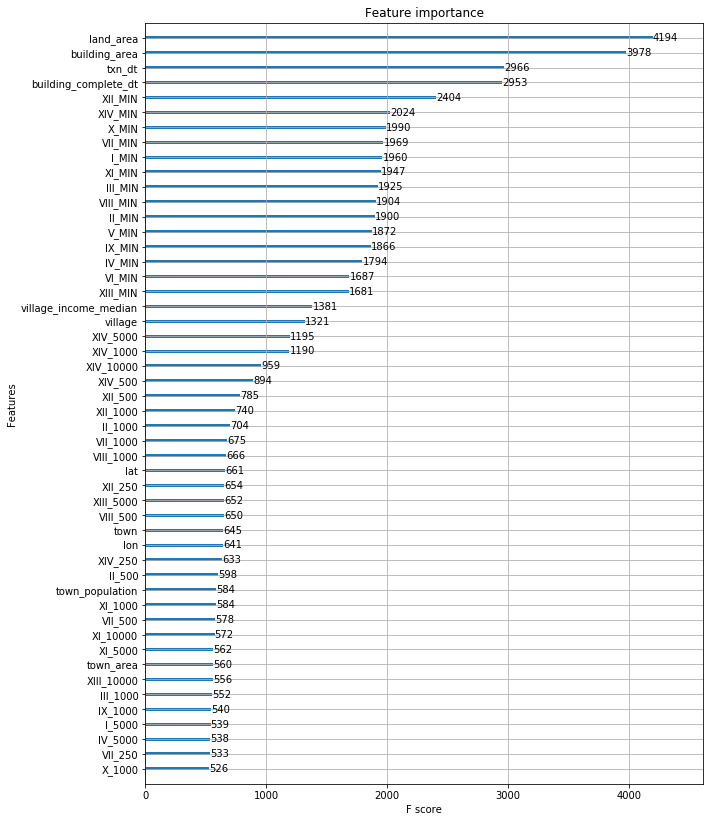

In [529]:
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=model, ax=ax, max_num_features=50)

In [530]:
test_ = test[X.columns]

In [531]:
pred = model.predict(test_)

In [532]:
pred_ = np.floor(np.expm1(pred))

In [533]:
test_id = test['building_id']

In [534]:
data = {'building_id':test_id, 'total_price':pred_}
sub = pd.DataFrame(data) 

In [535]:
sub.head()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,9510085.0
1,BTshNOJyKHnT2YIT,3998264.0
2,dhdymr0lV8N5kZOT,9496056.0
3,VEwyGGMcD56w5BOc,6663276.0
4,wmUeMoJZfsqaSX9b,944757.0


In [536]:
sub.to_csv('sub_10.csv',index=False)

,building_id,txn_dt,building_complete_dt,land_area,building_area,town,lat,lon,village_income_median,town_population,...,building_use_3,building_use_4,building_use_5,building_use_6,building_use_7,building_use_8,parking_way_0,parking_way_1,parking_way_2,building_material_5


In [ ]:
te